In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
import sklearn
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import sys

In [3]:
alpha = 0.7

### PROJECT INTRODUCTION

The World Health Organization (WHO) estimates that each year approximately one million people die from suicide, which represents a global mortality rate of 16 people per 100,000 or one death every 40 seconds. It is predicted that by 2020 the rate of death will increase to one every 20 seconds. Suicide is a top 10 factor of fatality worldwide and even has been the top 5 in some of the countries. Many studies have been looking into the trend and the demographic factors of suicide in order to come up with suitable coping actions and put the most resources to tackle this issue in the most needed place. 

The dataset I will be using comes from Kaggle. The information of it was pulled from four other relevant datasets: United Nations Development Program. (2018). Human development index (HDI), World Bank. (2018), Suicide in the Twenty-First Century [dataset], and World Health Organization. (2018). Suicide prevention. The factors in the dataset includes country, year of incident, sex, age, suicides numbers, population of nations, suicide per 100k population, HDI for the year, GDP for the year, GDP per capita, and generation. Basically, it can be interpreted as two major categories, demographic information of the person and the economic environment of the country, which are what most studies of suicide are focusing on. We would like to see which characteristics has higher chances to commit suicide, such as gender and age, and in what level of development of a country has more suicide, such as HDI and GDP. Also, I would take the time factor into analysis to understand if different time has different patterns so we might be able to predict the trend. All of the above contribute to the big mission of mitigating suicide. 

The dataset and analysis tasks have been done by others. In this project, besides replicating similar work I tried to bring in new factors - regime and human right proection level to the analysis. The regime and human right protection data was pulled from Center for Systemic Peace, a political database housed at Center for International Development and Conflict Management (CIDCM), at the University of Maryland, College Park. Regime is a score ranging from -10 to 10, where -10 represents complete autocracy and 10 represents complete democracy. Human right protection applies the same format and 10 represents fully protected human right.

In [4]:
df0 = pd.read_csv("suicide_data.csv")
df0.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


### DATA CLEANING

In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
country               27820 non-null object
year                  27820 non-null int64
sex                   27820 non-null object
age                   27820 non-null object
suicides_no           27820 non-null int64
population            27820 non-null int64
suicides/100k pop     27820 non-null float64
country-year          27820 non-null object
HDI for year          8364 non-null float64
 gdp_for_year ($)     27820 non-null object
gdp_per_capita ($)    27820 non-null int64
generation            27820 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [6]:
df0['country'].nunique()

101

* Make the colunm name more clean and succinct 

In [7]:
df0.rename(columns={'suicides_no':'suicides', 'suicides/100k pop':'suicides/100k',\
                   ' gdp_for_year ($) ':'gdp/year ', 'gdp_per_capita ($)':'gdp/capita'}, inplace=True)
df0.head()

,country,year,sex,age,suicides,population,suicides/100k,country-year,HDI for year,gdp/year,gdp/capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


* Delete countries whose data size are less than 50

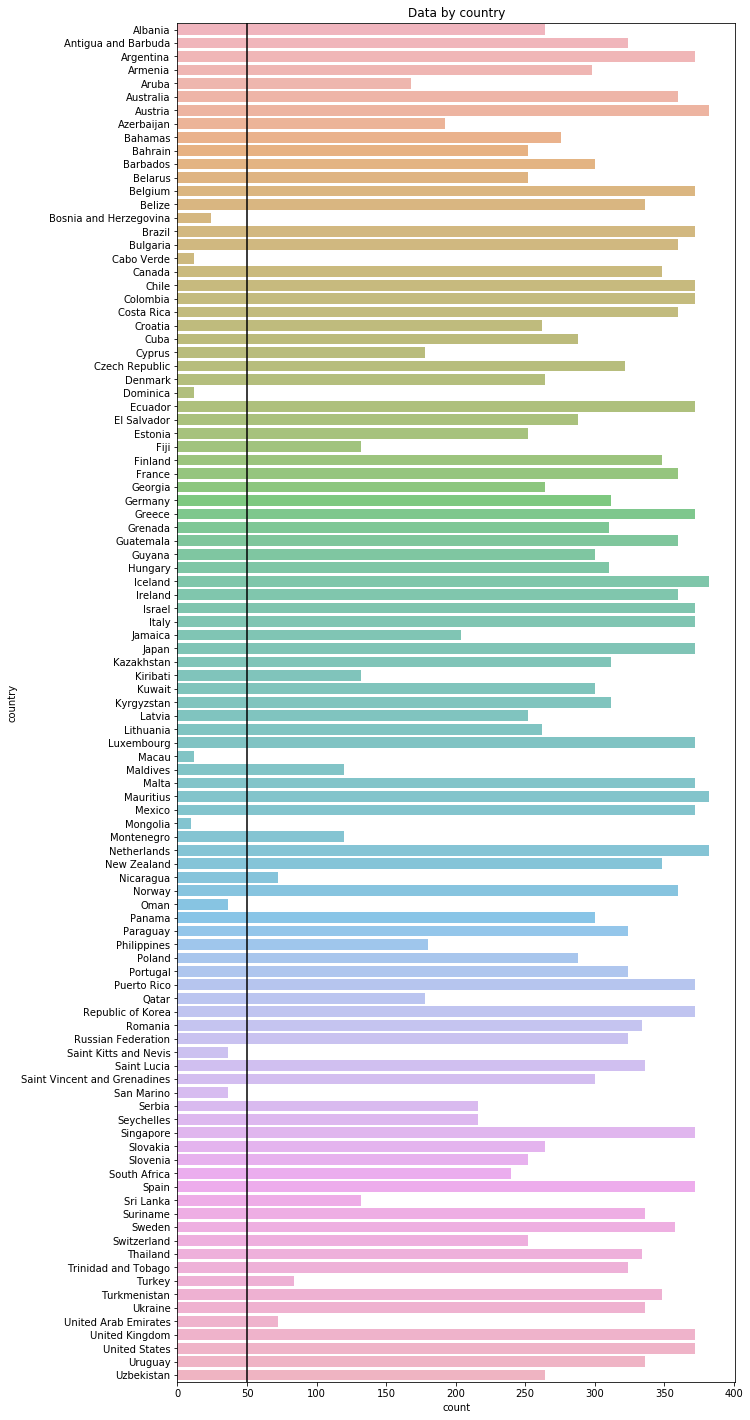

In [8]:
plt.figure(figsize=(10,25))
sns.countplot(y='country', data=df0, alpha=alpha)
plt.title('Data by country')
plt.axvline(x=50, color='k')
plt.show()

In [9]:
country_amountData = df0.groupby('country').count()['year'].reset_index()
country_amountData.sort_values(by='year', ascending=True). head(10)

,country,year
59,Mongolia,10
27,Dominica,12
54,Macau,12
17,Cabo Verde,12
14,Bosnia and Herzegovina,24
65,Oman,36
76,Saint Kitts and Nevis,36
79,San Marino,36
96,United Arab Emirates,72
63,Nicaragua,72


In [10]:
# delete top 8 countires from above that are less then 50
country_selectList = country_amountData[country_amountData['year'] > 50]['country'].reset_index()

In [11]:
df1 = pd.merge(df0, country_selectList, how='outer', indicator=True)
df1 = df1[df1['_merge']=='both']
df1.nunique()

country             93
year                32
sex                  2
age                  6
suicides          2084
population       25440
suicides/100k     5294
country-year      2306
HDI for year       305
gdp/year          2306
gdp/capita        2219
generation           6
index               93
_merge               1
dtype: int64

In [12]:
# we have 93 countries now from the original 101 to be considered in our analysis

* Delete the years whose data are significantly missing a lot', such as less than 200

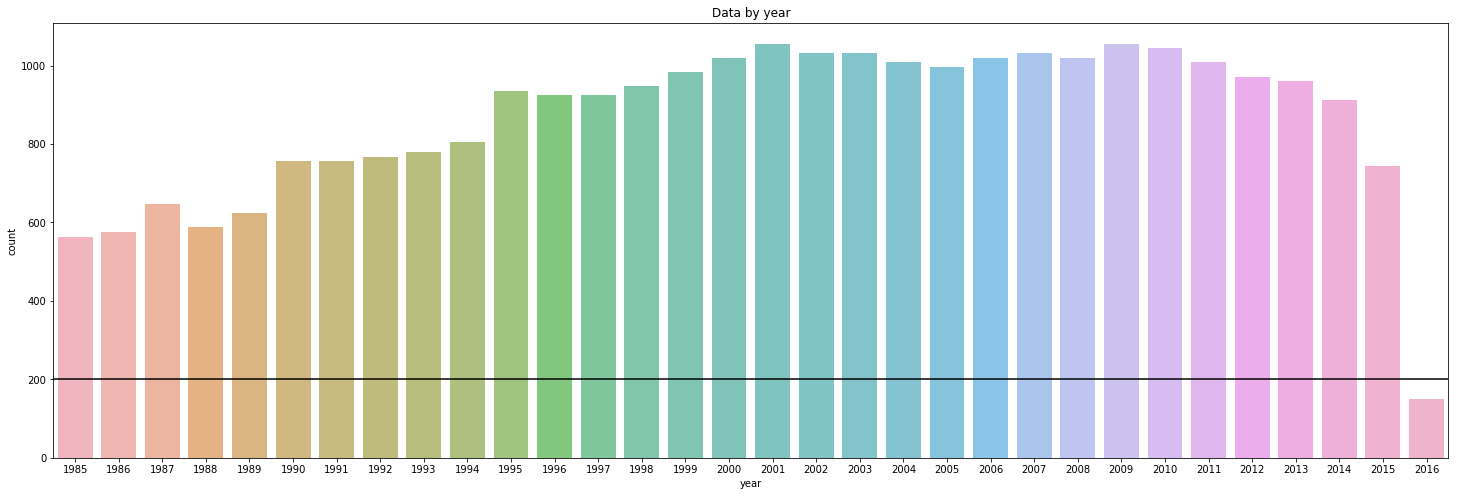

In [13]:
plt.figure(figsize=(25,8))
sns.countplot(x='year', data=df1, alpha=alpha)
plt.title('Data by year')
plt.axhline(y=200, color='k')
plt.show()

In [14]:
df2 = df1[df1['year'] != 2016]

In [31]:
# Delete 2016

* Delete the coloumns that have significant amount of missing data

In [15]:
number_NAN = len(df2) - df2['HDI for year'].count()
number_noNAN = len(df2)
number_NAN * 100 / number_noNAN

69.75120034919249

In [16]:
# Around 70% of the values in that columns are Nan's. Therefore, I deleted this column

In [17]:
df3 = df2.drop('HDI for year', axis=1)
df3.head()

,country,year,sex,age,suicides,population,suicides/100k,country-year,gdp/year,gdp/capita,generation,index,_merge
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,"2,156,624,900",796,Generation X,0.0,both
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,"2,156,624,900",796,Silent,0.0,both
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,"2,156,624,900",796,Generation X,0.0,both
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,"2,156,624,900",796,G.I. Generation,0.0,both
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,"2,156,624,900",796,Boomers,0.0,both


### DATA MERGING - regime (level of political freedom) of the country

In [18]:
regime = pd.read_csv("regime.csv")
regime = regime.rename(columns={'Entity': 'country', 'Year': 'year'})
regime.head()

,country,Code,year,Political regime type (Score),Human rights protection score,Total population (Gapminder)
0,Afghanistan,AFG,1800,NaN,NaN,3280000.0
1,Afghanistan,AFG,1816,-6.0,NaN,NaN
2,Afghanistan,AFG,1817,-6.0,NaN,NaN
3,Afghanistan,AFG,1818,-6.0,NaN,NaN
4,Afghanistan,AFG,1819,-6.0,NaN,NaN


In [19]:
df = pd.merge(df3, regime, how = 'inner', on = ['year', 'country'])
df.head()

,country,year,sex,age,suicides,population,suicides/100k,country-year,gdp/year,gdp/capita,generation,index,_merge,Code,Political regime type (Score),Human rights protection score,Total population (Gapminder)
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,"2,156,624,900",796,Generation X,0.0,both,ALB,-9.0,-0.535241,3116009.0
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,"2,156,624,900",796,Silent,0.0,both,ALB,-9.0,-0.535241,3116009.0
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,"2,156,624,900",796,Generation X,0.0,both,ALB,-9.0,-0.535241,3116009.0
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,"2,156,624,900",796,G.I. Generation,0.0,both,ALB,-9.0,-0.535241,3116009.0
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,"2,156,624,900",796,Boomers,0.0,both,ALB,-9.0,-0.535241,3116009.0


### DATA ANALYSIS

* Suicide by country

In [20]:
byCountry = df.groupby('country').mean().sort_values('suicides/100k', ascending=False).reset_index()

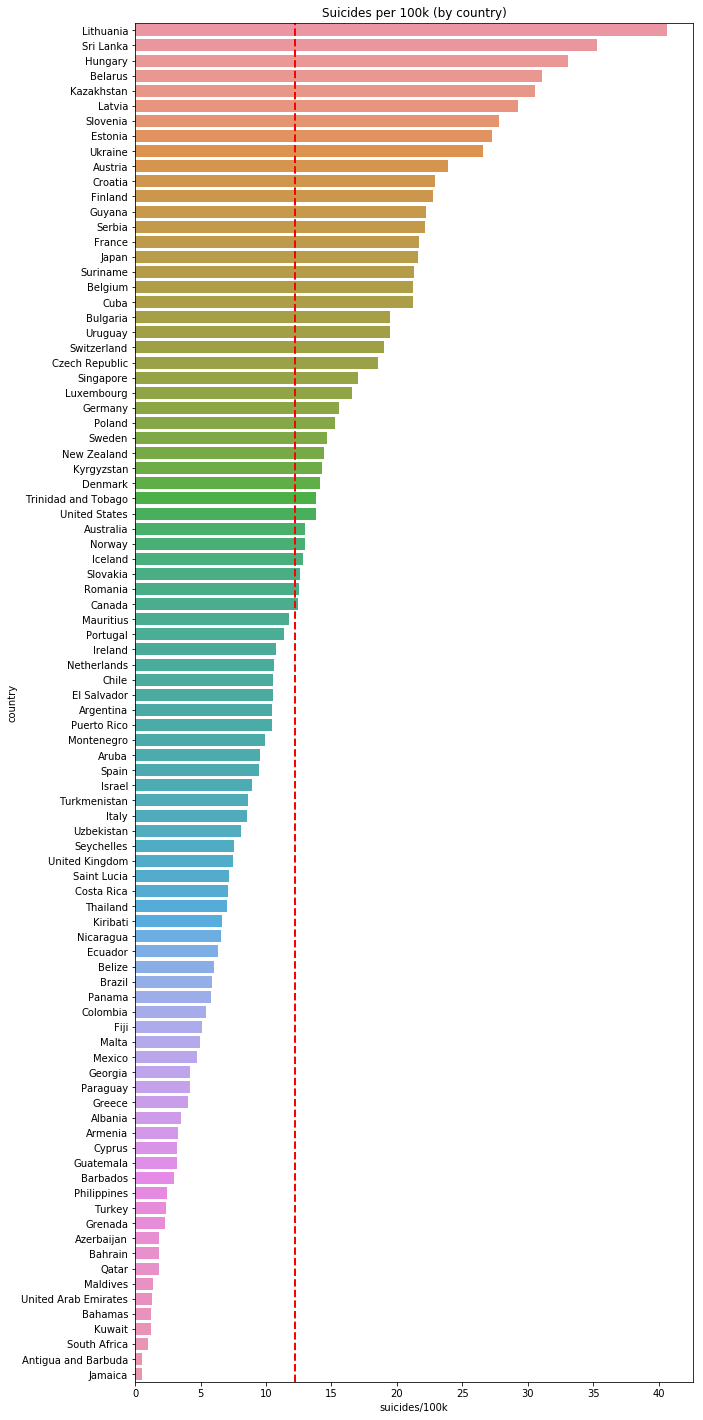

In [21]:
plt.figure(figsize=(10,25))
sns.barplot(x='suicides/100k', y ='country', data=byCountry)
plt.axvline(x = byCountry['suicides/100k'].mean(),color = 'red', ls='--', linewidth=2)
plt.title('Suicides per 100k (by country)')
plt.show()

Key points:
1. We can see what countries are above world avergae and what are below.
2. Lithuania, Sri Lanka, and Russia are the top 3 countries with more suicides per 100k.

* Suicide by year

In [22]:
byYear = df.groupby('year').mean().reset_index()

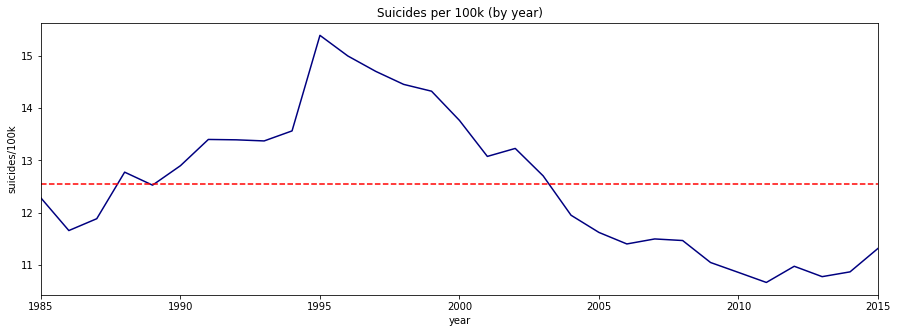

In [23]:
plt.figure(figsize=(15,5))
sns.lineplot(x='year', y='suicides/100k', data=byYear, color='navy')
plt.axhline(byYear['suicides/100k'].mean(), ls='--', color='red')
plt.title('Suicides per 100k (by year)')
plt.xlim(1985,2015)
plt.show()

Key points:
1. Suicide per 100K had raised from 1986 to 1995 and reached its peak, and had decreased to 2010.
2. There is a sign that suicide per 100K is rising in recent year.
3. It would be interesting to look into what happened in the period of 1990 to 1995 that caused the surge of suicide incidents.

* Suicide by sex

In [24]:
bySex     = df.groupby('sex').mean().reset_index()
bySexYear = df.groupby(['sex','year']).mean().reset_index()
bySexAge = df.groupby(['sex','age']).mean().sort_values('suicides/100k', ascending=True).reset_index()
bySexGeneration = df.groupby(['sex','generation']).mean().sort_values('suicides/100k', ascending=True).reset_index()

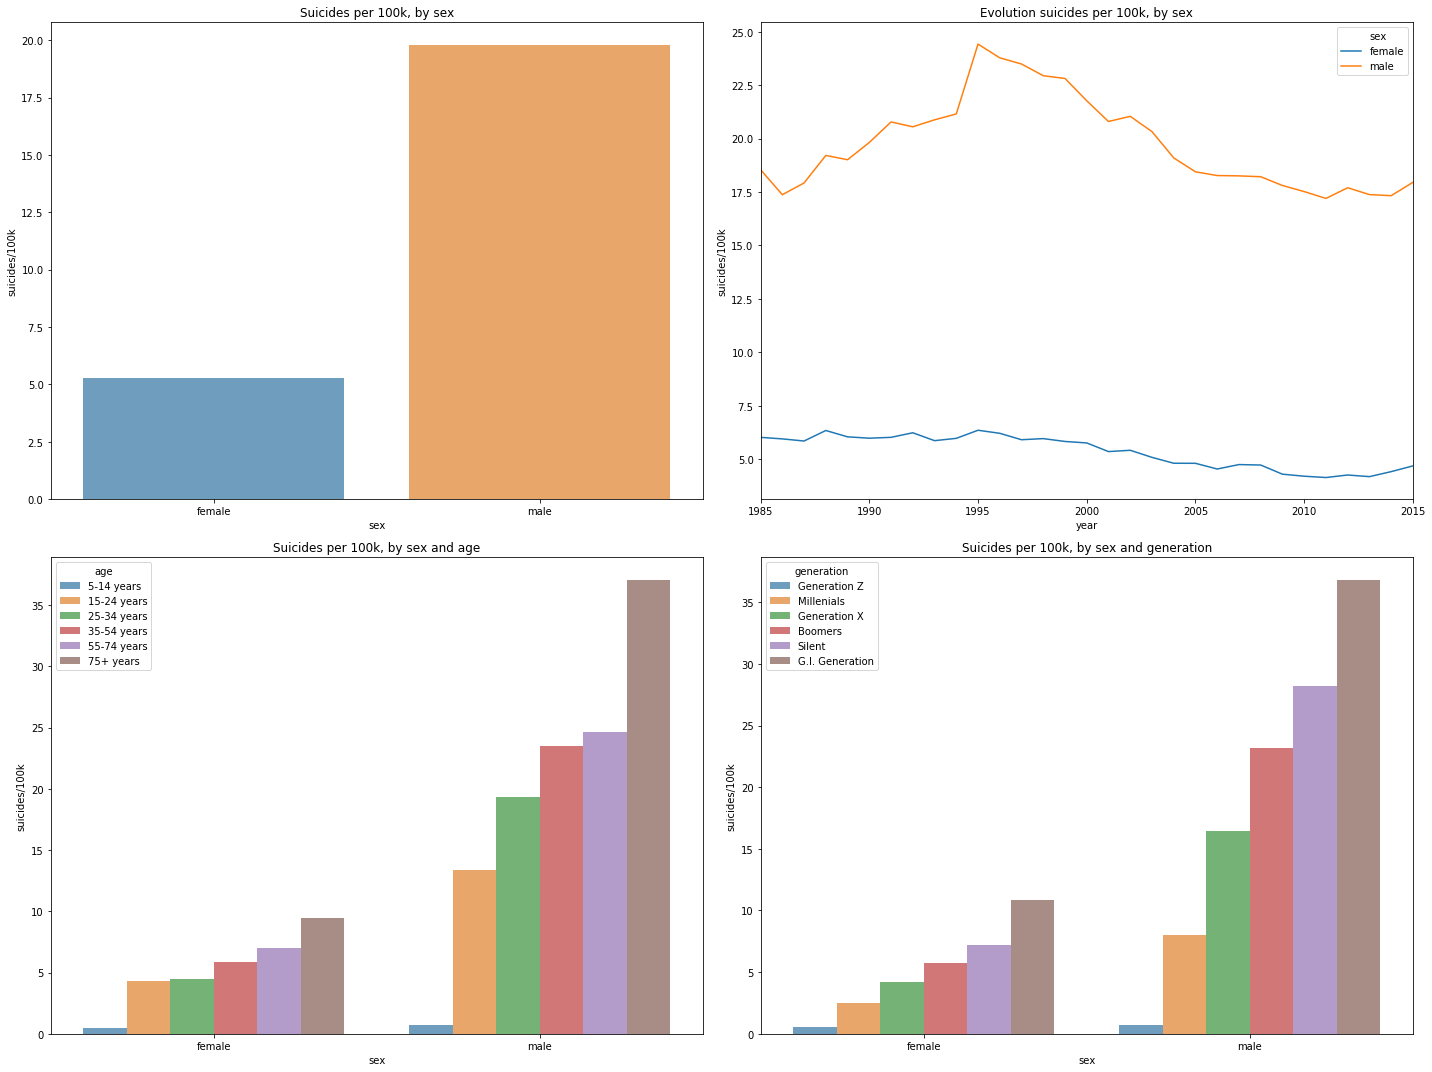

In [25]:
plt.figure(figsize=(20,15))
# By sex
plt.subplot(221)
sns.barplot(x='sex', y='suicides/100k', data=bySex, alpha=alpha)
plt.title('Suicides per 100k, by sex')
# Time evolution by sex
plt.subplot(222)
sns.lineplot(x='year', y='suicides/100k', data=bySexYear, hue='sex')
plt.xlim(1985,2015)
plt.title('Evolution suicides per 100k, by sex')
# By sex and age
plt.subplot(223)
sns.barplot(x='sex', y='suicides/100k', data=bySexAge, hue='age', alpha=alpha)
plt.title('Suicides per 100k, by sex and age')
# By sex and generation
plt.subplot(224)
sns.barplot(x='sex', y='suicides/100k', data=bySexGeneration, hue='generation', alpha=alpha)
plt.title('Suicides per 100k, by sex and generation')

plt.tight_layout()
plt.show()

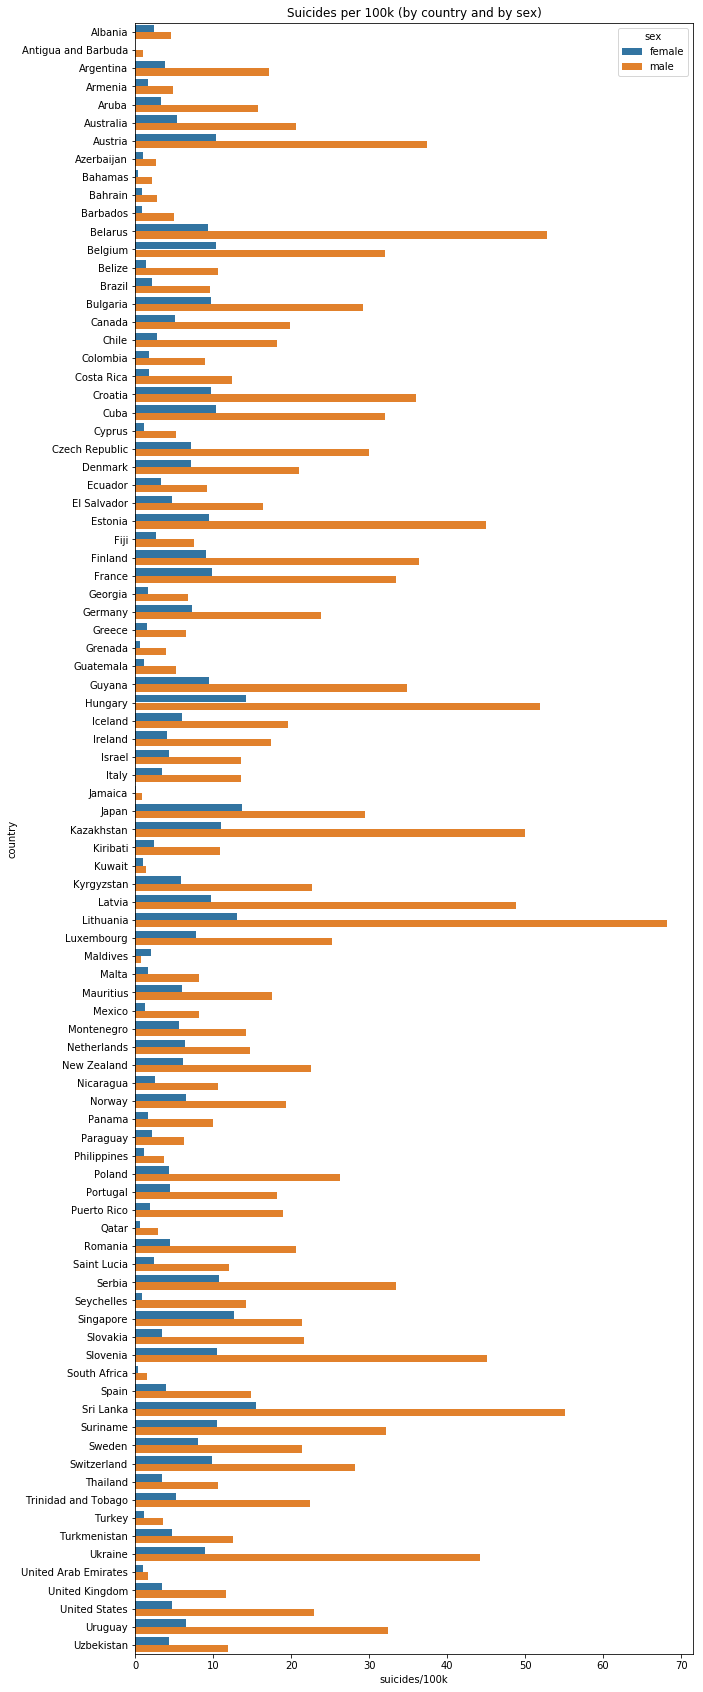

In [26]:
# By sex and country
byCountrySex = df.groupby(['country','sex']).mean().reset_index()
byCountrySex.head()
plt.figure(figsize=(10,30))
sns.barplot(y='country', x='suicides/100k', data=byCountrySex, hue='sex')
plt.title('Suicides per 100k (by country and by sex)')
plt.show()

Key points:
1. Men commit significantly more suicide than women.
2. The historical trend of suicide of men is close to the world overall trend, while women suicide remained relatively constant. This tells us that when looking into the cause, especially from 1990 to 1995, focusing on men's perspectives.
3. For both sex, suicides incidents increase while the age increases.
4. Nearly in all countries, men had more suicide than women.

* Suicide by age

In [27]:
byAge     = df.groupby('age').mean().sort_values('suicides/100k', ascending=True).reset_index()
byAgeYear = df.groupby(['age','year']).mean().sort_values('suicides/100k', ascending=True).reset_index()
byAgeSex = df.groupby(['age','sex']).mean().sort_values('suicides/100k', ascending=True).reset_index()
byAgeGen = df.groupby(['age','generation']).mean().sort_values('suicides/100k', ascending=True).reset_index()

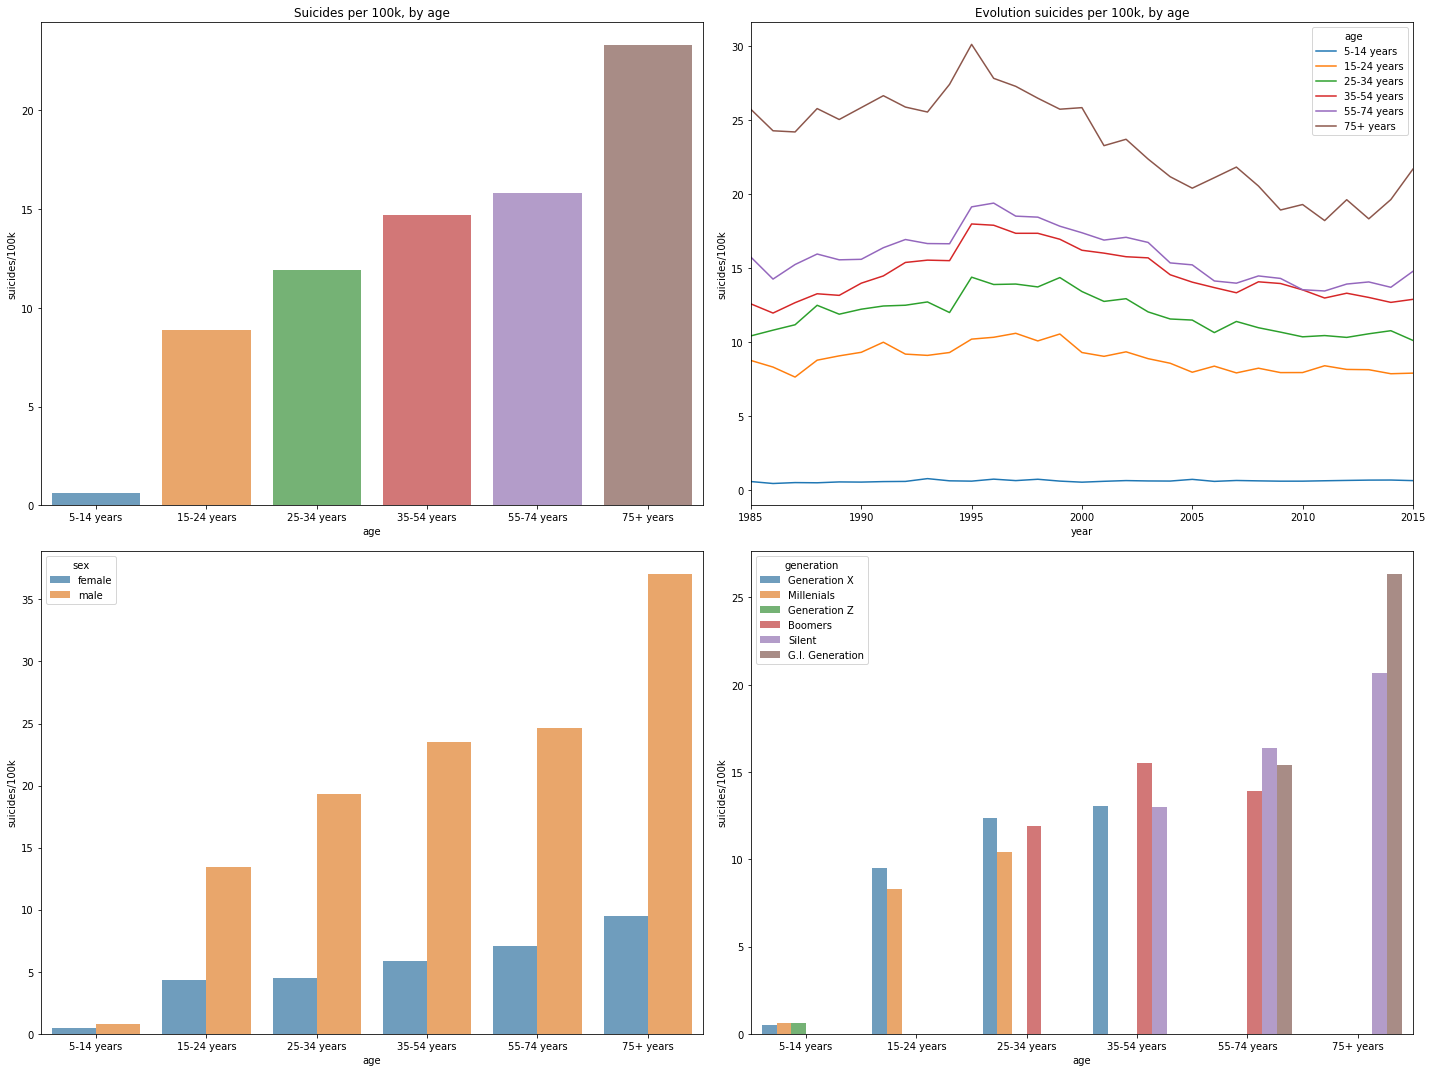

In [28]:
plt.figure(figsize=(20,15))
# By age
plt.subplot(221)
sns.barplot(x='age', y='suicides/100k', data=byAge, alpha=alpha)
plt.title('Suicides per 100k, by age')
# Time evolution by age
plt.subplot(222)
sns.lineplot(x='year', y='suicides/100k', data=byAgeYear, hue='age')
plt.xlim(1985,2015)
plt.title('Evolution suicides per 100k, by age')
# 
plt.subplot(223)
sns.barplot(x='age', y='suicides/100k', data=byAgeSex, hue='sex', alpha=alpha)
plt.subplot(224)
sns.barplot(x='age', y='suicides/100k', data=byAgeGen, hue='generation', alpha=alpha)

plt.tight_layout()
plt.show()

Key points:
1. The number of suicides per 100k increases with the age.
2. The number of suicides per 100k decreases from 1995 to 2015 in all age groups except 5-14 year, which slightly increases.
3. The peak of suicides in 1995 is more striking for people with ages +75.
4. In all age groups there are more male suicides per 100k than female ones.

* Suicide and GDP/capita

C:\Users\Rodney_NB\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


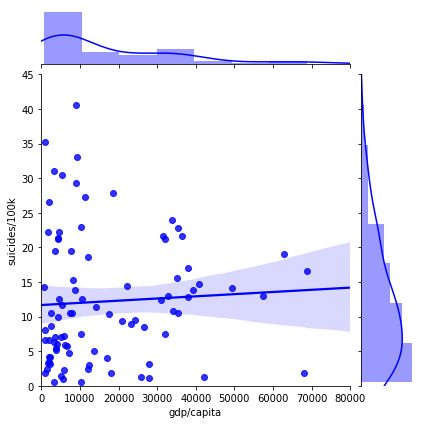

In [29]:
g = sns.jointplot(x="gdp/capita", y="suicides/100k", data=byCountry, kind='regresion', \
              xlim=(-100,80000), ylim=(0,45), color='blue')

Key point:
There is no significant correlation between GDP/capita and suicide.

* Suicide and regime (political freedom)

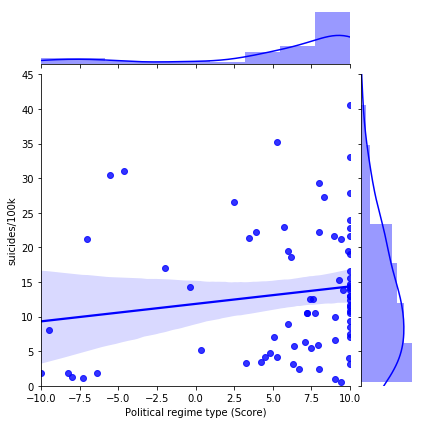

In [33]:
g = sns.jointplot(x="Political regime type (Score)", y="suicides/100k", data=byCountry, kind='regresion', \
              xlim=(-10,10), ylim=(0,45), color='blue')

* Suicide and human right protection

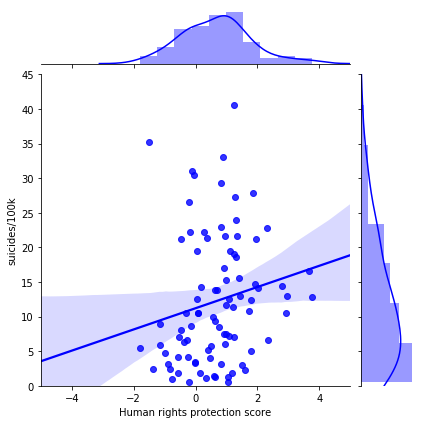

In [34]:
g = sns.jointplot(x="Human rights protection score", y="suicides/100k", data=byCountry, kind='regresion', \
              xlim=(-5,5), ylim=(0,45), color='blue')